In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from dataset_reader import Traces_Dataset

from exp_generate_data import exp_formalism_data_generator
from exp_hh_model import HH_model_exp

In [2]:
dataset = Traces_Dataset('../dataset_test.csv')

In [3]:
target_num = 2
target_prestep_V = int(dataset.prestep_V[target_num])
target_step_V1 = int(dataset.step_Vs[target_num].numpy()[0])
target_dV = dataset.step_Vs[target_num].numpy()[1] - dataset.step_Vs[target_num].numpy()[0]
target_prestep_V, target_step_V1, target_dV

(-122, -41, 11.0)

In [4]:
t = np.arange(0.0, 6.0, 0.01)
target_params = dataset.params[target_num].numpy()

sim_setup = {'prestep_V': target_prestep_V, 'step_Vs': dataset.step_Vs[target_num].numpy(), 't':t}
params = {'p': target_params[0], 
          'g_max': target_params[1], 
          'E_rev': target_params[2], 
                 'a_m': target_params[3], 
                 'b_m': target_params[4], 
                 'delta_m': target_params[5], 
                 's_m': target_params[6]}
print(params)

model = HH_model_exp(params, sim_setup)
model.simulation()
if model.check_current_ss() and model.check_steady_state_curve(): 
    target_max_ind_arr = model.max_index_array
    target_current_traces = model.current_traces

target_max_ind_arr.shape, target_current_traces.shape

{'p': 4.0, 'g_max': 106.22407, 'E_rev': -71.32051, 'a_m': 2.2097604, 'b_m': 2.8441272, 'delta_m': 0.96789503, 's_m': -14.623417}


/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/Identifiability /../exp_hh_model.py:85: RuntimeWarning: divide by zero encountered in divide
  diff_arr = np.abs((self.current_traces[i, :][1:] - self.current_traces[i, :][:-1]) / (self.current_traces[i, :][:-1] - self.current_traces[i, :][0]))


((8,), (8, 600))

generate samples using the target sim setup

In [5]:
# p inclusive on both ends
params_bounds = {'p': (1, 4), 
                 'g_max': (100, 140), 
                 'E_rev': (-100, -60), 
                 'a_m': (0, 100), 
                 'b_m': (0, 100), 
                 'delta_m': (0, 1), 
                 's_m': (-100, 0)}

# prestep_V bounds -> only take values from lb to up with increment of 10
# step_Vs bounds -> the lower bounds on step_Vs, generate an array of step_Vs using increment of 10 with 11 elements. 
# dV_bd inclusive on both ends

exp_setupNbounds = {'prestep_V_bounds': (target_prestep_V, target_prestep_V), 'step_Vs_lb': (target_step_V1, target_step_V1), 'dV_bd': (target_dV, target_dV), 'n_traces': 8, 't': t}

# sim_setup = {'prestep_V': -100, 'step_Vs': np.linspace(-20, 100, 13), 't': np.arange(0.0, 6.0, 0.01)}

data_generator = exp_formalism_data_generator(params_bounds, exp_setupNbounds)
n_samples = 1000
data_generator.generate_data_dotty_plots(n_samples)
data_generator.dataset.shape


/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/Identifiability /../exp_hh_model.py:31: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((V - self.V_2m) / self.s_m))
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/Identifiability /../exp_hh_model.py:40: RuntimeWarning: overflow encountered in exp
  return (tau_0m * np.exp(self.delta_m * ((V - self.V_2m) / self.s_m))) / (1 + np.exp((V - self.V_2m) / self.s_m))
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/Identifiability /../exp_hh_model.py:61: RuntimeWarning: divide by zero encountered in divide
  return self.m_infty(V) + (self.m_infty(self.prestep_V) - self.m_infty(V)) * np.exp(- self.t / self.tau_m(V))
/Users/maxwellyue/Documents/GitHub/Compute-Canada-Research/Exp_rates_generalized_exp_setup/Identifiability /../exp_hh_model.py:61: RuntimeWarning: invalid value encountered in divide
  r

(1000, 4815)

In [6]:
max_ind_arrs = data_generator.dataset[:, :8]
current_traces = data_generator.dataset[:, 8:-7].reshape(-1, 8, 600)
params = data_generator.dataset[:, -7:]
max_ind_arrs.shape, current_traces.shape, params.shape

((1000, 8), (1000, 8, 600), (1000, 7))

Visualize sample and target

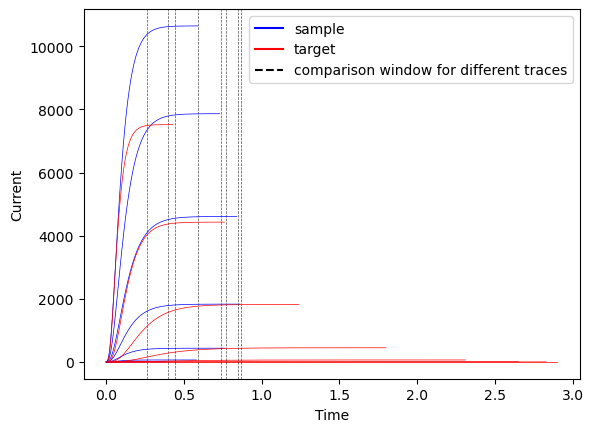

In [12]:
sample = 5
# Plotting 8 traces
for i in range(8):
    stop = int(max_ind_arrs[sample, i])
    target_stop = int(target_max_ind_arr[i])
    plt.plot(t[:stop], current_traces[sample, i, :stop], color = 'blue', linewidth = 0.5)
    plt.plot(t[:target_stop], target_current_traces[i, :target_stop], color = 'red', linewidth = 0.5)
    plt.axvline(x = min(t[stop], t[target_stop]), color='black', linestyle='--', linewidth = 0.5, alpha = 0.7)


plt.xlabel('Time')
plt.ylabel('Current')
plt.plot([],[], color='blue', label=f'sample')
plt.plot([],[], color='red', label=f'target')
plt.plot([],[], color='black', linestyle='--', label='comparison window for different traces')
plt.legend()
plt.show()
# current_traces[0]

define obj functions

In [8]:
def obj_trace(sample, trace):
    '''
    find the area difference in the rising phase instead of the whole simulation. 
    This can be done by defining a window using the earlier threshold between two sample traces. 
    the fct is comparing two traces from the same experiment in two different samples. 
    '''
    # find the earlier threshold index + 1. 
    stop_ind = int(min(max_ind_arrs[sample, trace], target_max_ind_arr[trace]))
    #print(sample1, sample2, trace)
    #print(np.where(selected_t[sample1, trace] == -1)[0][0], np.where(selected_t[sample2, trace] == -1)[0][0])
    # we calculate the (avg over stop_ind points) 

    # diff_area_one_trace = np.trapz(np.abs(selected_current_traces_3d[sample1, trace, :stop_ind] - selected_current_traces_3d[sample2, trace, :stop_ind]), dataset_generator.t[:stop_ind]) / np.trapz(np.maximum(selected_current_traces_3d[sample1, trace, :stop_ind], selected_current_traces_3d[sample2, trace, :stop_ind]), dataset_generator.t[:stop_ind])
    diff_area_one_trace = np.trapz(np.abs(current_traces[sample, trace, :stop_ind] - target_current_traces[trace, :stop_ind]), t[:stop_ind]) / np.trapz(np.maximum(current_traces[sample, trace, :stop_ind], target_current_traces[trace, :stop_ind]), t[:stop_ind])
    
    
    return diff_area_one_trace

In [9]:
def obj(sample): 
    diff_area = np.mean([obj_trace(sample, trace) for trace in range(target_current_traces.shape[0])])
    # diff_params_square = np.sum(np.square(selected_params[sample1] - selected_params[sample2]))
    return diff_area #, diff_params_square

In [10]:
fitness_list = [obj(sample) for sample in range(n_samples)]
param_lists = []
for i in range(params.shape[1]):
    param_list = [params[sample, i] for sample in range(n_samples)]
    param_lists.append(param_list)

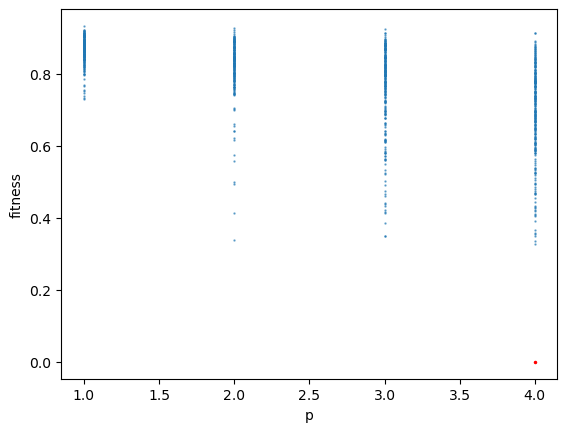

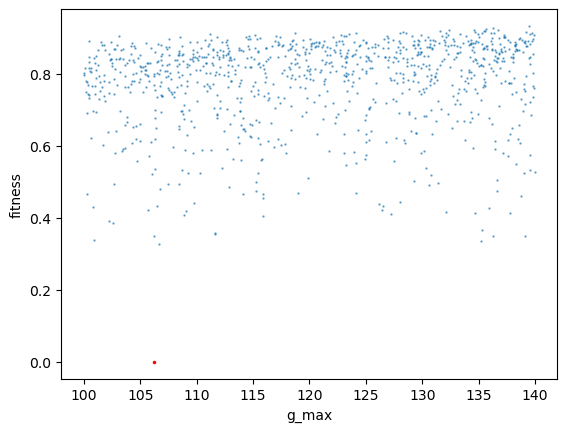

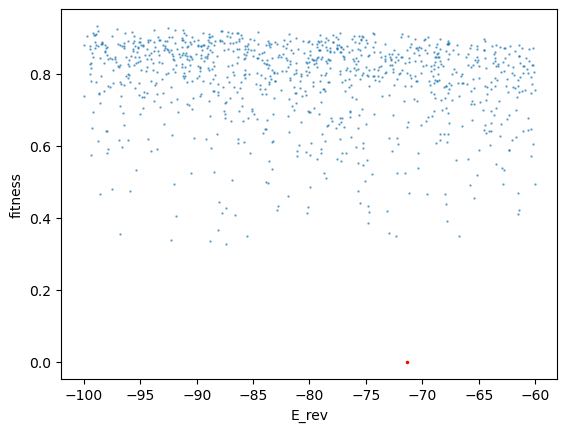

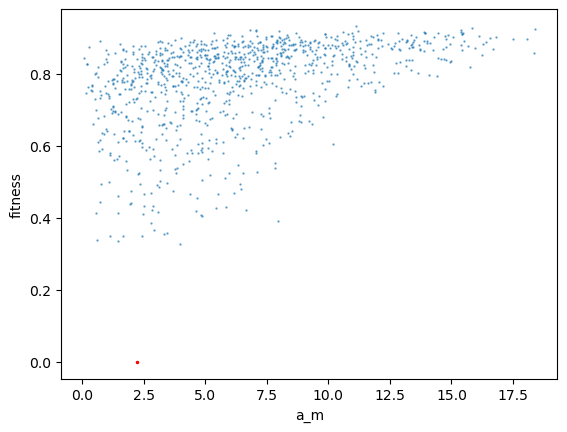

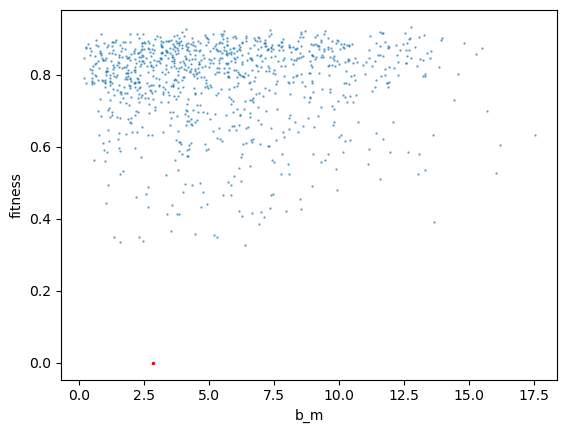

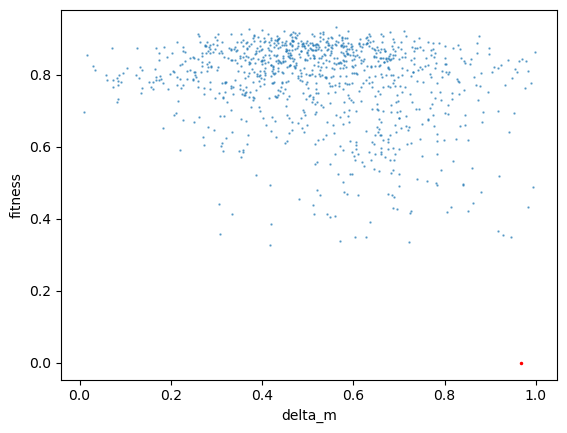

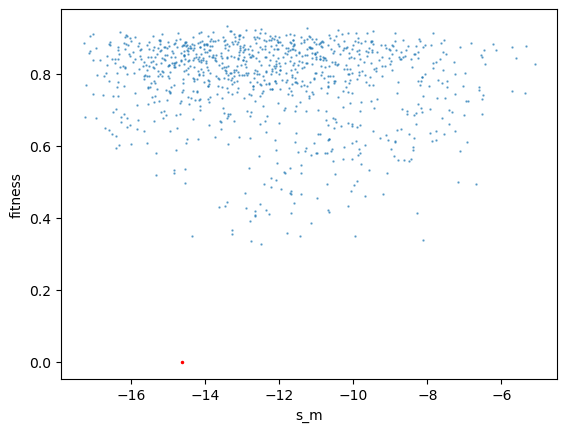

In [11]:
params_names = list(params_bounds.keys())

for i in range(params.shape[1]):
    plt.figure()
    plt.scatter(param_lists[i], fitness_list, alpha=0.6, s=0.5)
    plt.plot(target_params[i], 0, 'ro', markersize=1.5)
    plt.xlabel(params_names[i])
    plt.ylabel('fitness')